In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math
import copy

In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './output'

In [3]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

# Dataloader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

# Model

In [7]:
class DeepModelWithAttention(nn.Module):
    def __init__(self, desired_sum):
        super(DeepModelWithAttention, self).__init__()
        self.desired_sum = desired_sum

        self.attn = nn.MultiheadAttention(embed_dim=2, num_heads= 1)
        self.fc = nn.Linear(2, 1)
        
    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.mean(dim = 1)
        output = self.fc(attn_output).squeeze(-1) 
        
        output = F.softmax(output, dim = 0) * self.desired_sum

        return output

In [8]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [9]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train Function

In [11]:
def pretrain_meta(meta_model, optimizer_M, task_num):
    target = torch.full((task_num, 1, 1), 2.0).to(device)
    criterion = nn.MSELoss()

    print("Pretrain on meta_model")
    for epoch in range(400):
        prev_outputs = None
        for k in range (task_num):
            past_output = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            outputs = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            diff = past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]
            diff = diff.unsqueeze(0)
            if (prev_outputs == None):
                prev_outputs = diff
            else:
                prev_outputs = torch.cat((prev_outputs, diff), dim=0)

        meta_out = meta_model(prev_outputs).view(-1, 1, 1 )

        meta_model.train()
        optimizer_M.zero_grad()
        loss = criterion(meta_out, target)
        loss.backward()
        optimizer_M.step()
        
        '''if((epoch + 1) % 100 == 0):
            print(f'Epoch [{epoch+1}/{400}], Loss: {loss.item():.4f}')'''

In [12]:
task_num = 1
meta_model = DeepModelWithAttention(desired_sum = 2 * task_num).to(device)
optimizer_M = optim.Adam(meta_model.parameters(), lr=0.001)
pretrain_meta(meta_model, optimizer_M, task_num)

Pretrain on meta_model


In [13]:
x = torch.rand(2, 4, 2)
y = 2
print(x)

tensor([[[0.5928, 0.8652],
         [0.2944, 0.0012],
         [0.8218, 0.8225],
         [0.9378, 0.7714]],

        [[0.0484, 0.0697],
         [0.1482, 0.5579],
         [0.5317, 0.3011],
         [0.8184, 0.4968]]])


In [14]:
print(x * y)

tensor([[[1.1856, 1.7304],
         [0.5888, 0.0025],
         [1.6437, 1.6451],
         [1.8756, 1.5428]],

        [[0.0968, 0.1395],
         [0.2965, 1.1158],
         [1.0633, 0.6021],
         [1.6367, 0.9936]]])


In [15]:
print(torch.mean(x * y, dim = (1,2)))

tensor([1.2768, 0.7430])


In [16]:
z = torch.tensor([[0.0731, 0.5404],
         [0.3333, 0.8707],
         [1.1473, 1.9887],
         [0.6462, 1.1840]])
z.mean()

tensor(0.8480)

In [29]:
def train(model, task_num, criterion, optimizer, prev_models, task_dataloaders, epoches = 4):
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}
    distribution_factor  = 20

    if (task_num != 0):
        meta_model = DeepModelWithAttention(desired_sum = 2 * task_num).to(device)
        optimizer_M = optim.Adam(meta_model.parameters(), lr=0.001)
        pretrain_meta(meta_model, optimizer_M, task_num)
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            model.train()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            random_data = torch.rand(256, 1, 28, 28).to(device)
            random_data = (random_data - 0.5) / 0.5
            random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
            fake_output = model(random_data)
            dis_loss = distribution_factor * criterion(fake_output, random_target)

            reg_loss = 0
            prev_outputs = None
            if (task_num != 0):
                meta_model.eval()
                for k, prev_mod in enumerate(prev_models):
                    with torch.no_grad():
                        past_output = prev_mod(images)
                    diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
                    diff = diff.unsqueeze(0)
                    if (prev_outputs == None):
                        prev_outputs = diff
                    else:
                        prev_outputs = torch.cat((prev_outputs, diff), dim=0)

                '''with torch.no_grad():
                    meta_out = meta_model(prev_outputs).view(-1, 1, 1)'''
                
                meta_out = 2
                mean_diff = torch.mean(prev_outputs, dim = (1, 2))
                reg_loss = torch.sum(meta_out * mean_diff)

                for k in range(prev_outputs.shape[0]):
                    reg_loss += torch.mean(2 * prev_outputs[k])
                
                '''if (batch_num == 0):
                    print(meta_out)'''
                    
            loss = criterion(outputs[:,:valid_out_dim], labels) + dis_loss + reg_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            '''if (task_num != 0):
                meta_model.train()
                prev_outputs = None
                outputs = outputs.detach()
                for k, prev_mod in enumerate(prev_models):
                    with torch.no_grad():
                        past_output = prev_mod(images)
                    
                    diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
                    diff = diff.unsqueeze(0)
                    if (prev_outputs == None):
                        prev_outputs = diff
                    else:
                        prev_outputs = torch.cat((prev_outputs, diff), dim=0)

                meta_out = meta_model(prev_outputs).view(-1, 1, 1)
                meta_loss = torch.mean(meta_out * prev_outputs)

                optimizer_M.zero_grad()
                meta_loss.backward()
                optimizer_M.step()'''

            batch_num += 1

        adjust_learning_rate(optimizer)

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(model, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
        if(task_num != 0):
            logging.info(f'loss:{loss.item()}, reg_loss:{reg_loss:.4f}')
    
    return model, task_accuracies

# Train

In [30]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    

def train_split_task(task_name, task_dataloaders):
    print(f"Training on {task_name}")
    prev_models = []
    model = MLP_Enhance()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
    criterion = nn.CrossEntropyLoss()

    epochs, lr = 3, 0.005
    file_name = f"{output_dir}/{task_name}_epochs={epochs}"
    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'

    setup_logging(log_file_name)
    all_accuracies = []
    for task in [0, 1, 2, 3, 4]:
        model, task_accuracies = train(model, task, criterion, optimizer, prev_models, task_dataloaders, epoches = 4)
        all_accuracies.append(task_accuracies)
        prev_models.append(copy.deepcopy(model))

    plot_task_acc_history(all_accuracies, img_file_name, epochs)

2024-06-02 02:35:38,549 - INFO - ##########Task 0##########
2024-06-02 02:35:38,550 - INFO - Epoch 0


Training on 0


2024-06-02 02:35:45,255 - INFO - Epoch: 0, , Task 0 acc: 85.5230, Task avg acc:85.5230
2024-06-02 02:35:45,256 - INFO - Epoch 1
2024-06-02 02:35:51,149 - INFO - Epoch: 1, , Task 0 acc: 96.7395, Task avg acc:96.7395
2024-06-02 02:35:51,151 - INFO - Epoch 2
2024-06-02 02:35:57,647 - INFO - Epoch: 2, , Task 0 acc: 93.9015, Task avg acc:93.9015
2024-06-02 02:35:57,647 - INFO - Epoch 3
2024-06-02 02:36:03,511 - INFO - Epoch: 3, , Task 0 acc: 96.3010, Task avg acc:96.3010


Pretrain on meta_model


2024-06-02 02:36:04,684 - INFO - ##########Task 1##########
2024-06-02 02:36:04,684 - INFO - Epoch 0
2024-06-02 02:36:12,211 - INFO - Epoch: 0, , Task 0 acc: 62.7232, Task 1 acc: 21.4678, Task avg acc:42.0955
2024-06-02 02:36:12,213 - INFO - loss:47.51426696777344, reg_loss:0.1963
2024-06-02 02:36:12,214 - INFO - Epoch 1
2024-06-02 02:36:19,883 - INFO - Epoch: 1, , Task 0 acc: 71.1974, Task 1 acc: 18.8082, Task avg acc:45.0028
2024-06-02 02:36:19,884 - INFO - loss:47.265052795410156, reg_loss:0.2030
2024-06-02 02:36:19,885 - INFO - Epoch 2
2024-06-02 02:36:27,599 - INFO - Epoch: 2, , Task 0 acc: 72.7280, Task 1 acc: 21.3680, Task avg acc:47.0480
2024-06-02 02:36:27,600 - INFO - loss:47.58672332763672, reg_loss:0.1810
2024-06-02 02:36:27,601 - INFO - Epoch 3
2024-06-02 02:36:35,276 - INFO - Epoch: 3, , Task 0 acc: 72.6722, Task 1 acc: 22.6895, Task avg acc:47.6808
2024-06-02 02:36:35,277 - INFO - loss:47.484195709228516, reg_loss:0.1564


Pretrain on meta_model


2024-06-02 02:36:36,652 - INFO - ##########Task 2##########
2024-06-02 02:36:36,653 - INFO - Epoch 0
2024-06-02 02:36:46,386 - INFO - Epoch: 0, , Task 0 acc: 73.9955, Task 1 acc: 7.0396, Task 2 acc: 26.5805, Task avg acc:35.8719
2024-06-02 02:36:46,387 - INFO - loss:48.33284378051758, reg_loss:0.3824
2024-06-02 02:36:46,388 - INFO - Epoch 1
2024-06-02 02:36:56,080 - INFO - Epoch: 1, , Task 0 acc: 72.8157, Task 1 acc: 7.3138, Task 2 acc: 36.0722, Task avg acc:38.7339
2024-06-02 02:36:56,082 - INFO - loss:47.885643005371094, reg_loss:0.3447
2024-06-02 02:36:56,082 - INFO - Epoch 2
2024-06-02 02:37:05,773 - INFO - Epoch: 2, , Task 0 acc: 72.9751, Task 1 acc: 8.1449, Task 2 acc: 41.8822, Task avg acc:41.0008
2024-06-02 02:37:05,775 - INFO - loss:48.19593048095703, reg_loss:0.3360
2024-06-02 02:37:05,776 - INFO - Epoch 3
2024-06-02 02:37:15,471 - INFO - Epoch: 3, , Task 0 acc: 74.0593, Task 1 acc: 8.6602, Task 2 acc: 42.5108, Task avg acc:41.7434
2024-06-02 02:37:15,473 - INFO - loss:48.178

Pretrain on meta_model


2024-06-02 02:37:17,108 - INFO - ##########Task 3##########
2024-06-02 02:37:17,109 - INFO - Epoch 0
2024-06-02 02:37:29,461 - INFO - Epoch: 0, , Task 0 acc: 72.3613, Task 1 acc: 7.0811, Task 2 acc: 21.2823, Task 3 acc: 5.9293, Task avg acc:26.6635
2024-06-02 02:37:29,463 - INFO - loss:48.88599395751953, reg_loss:0.6012
2024-06-02 02:37:29,464 - INFO - Epoch 1
2024-06-02 02:37:41,884 - INFO - Epoch: 1, , Task 0 acc: 71.3728, Task 1 acc: 5.3690, Task 2 acc: 21.0399, Task 3 acc: 15.9457, Task avg acc:28.4318
2024-06-02 02:37:41,885 - INFO - loss:48.73701858520508, reg_loss:0.5935
2024-06-02 02:37:41,885 - INFO - Epoch 2
2024-06-02 02:37:54,183 - INFO - Epoch: 2, , Task 0 acc: 71.2293, Task 1 acc: 5.1363, Task 2 acc: 20.8513, Task 3 acc: 21.7599, Task avg acc:29.7442
2024-06-02 02:37:54,185 - INFO - loss:48.74620819091797, reg_loss:0.5909
2024-06-02 02:37:54,186 - INFO - Epoch 3
2024-06-02 02:38:06,516 - INFO - Epoch: 3, , Task 0 acc: 70.7828, Task 1 acc: 4.9618, Task 2 acc: 21.0129, Task

Pretrain on meta_model


2024-06-02 02:38:08,321 - INFO - ##########Task 4##########
2024-06-02 02:38:08,322 - INFO - Epoch 0
2024-06-02 02:38:22,904 - INFO - Epoch: 0, , Task 0 acc: 64.8836, Task 1 acc: 4.7374, Task 2 acc: 17.7892, Task 3 acc: 14.8191, Task 4 acc: 0.0170, Task avg acc:20.4492
2024-06-02 02:38:22,906 - INFO - loss:49.19590759277344, reg_loss:0.6078
2024-06-02 02:38:22,907 - INFO - Epoch 1
2024-06-02 02:38:37,414 - INFO - Epoch: 1, , Task 0 acc: 64.1342, Task 1 acc: 4.5961, Task 2 acc: 17.9777, Task 3 acc: 13.2401, Task 4 acc: 0.1104, Task avg acc:20.0117
2024-06-02 02:38:37,416 - INFO - loss:49.31145095825195, reg_loss:0.5967
2024-06-02 02:38:37,417 - INFO - Epoch 2
2024-06-02 02:38:51,972 - INFO - Epoch: 2, , Task 0 acc: 63.7915, Task 1 acc: 4.5462, Task 2 acc: 17.8341, Task 3 acc: 12.1053, Task 4 acc: 0.2208, Task avg acc:19.6996
2024-06-02 02:38:51,974 - INFO - loss:49.072410583496094, reg_loss:0.5876
2024-06-02 02:38:51,975 - INFO - Epoch 3
2024-06-02 02:39:06,980 - INFO - Epoch: 3, , Task

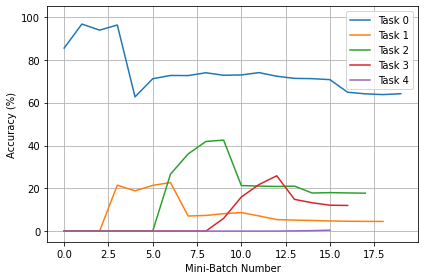

In [31]:
train_split_task("0", task_dataloaders)